<a href="https://colab.research.google.com/github/gavbdheiver/complex_demand_forecasting/blob/main/GB_demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [349]:
# packages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools

from math import sqrt
from numpy import concatenate
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

# multivariate output stacked lstm example
from numpy import array
from numpy import hstack
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# data import
demo = pd.read_csv('/content/demographics.csv')
event = pd.read_csv('/content/event_calendar.csv')
event['YearMonth']  = pd.to_datetime(event['YearMonth'],format='%Y%m')
historical = pd.read_csv('/content/historical_volume.csv')
historical['YearMonth'] = pd.to_datetime(historical['YearMonth'],format='%Y%m')
soda = pd.read_csv('/content/industry_soda_sales.csv')
soda['YearMonth'] = pd.to_datetime(soda['YearMonth'],format='%Y%m')
industry = pd.read_csv('/content/industry_volume.csv')
industry['YearMonth'] = pd.to_datetime(industry['YearMonth'],format='%Y%m')
price = pd.read_csv('/content/price_sales_promotion.csv')
price['YearMonth'] = pd.to_datetime(price['YearMonth'],format='%Y%m')
weather = pd.read_csv('/content/weather.csv')
weather['YearMonth'] = pd.to_datetime(weather['YearMonth'],format='%Y%m')

In [350]:
sku = historical.merge(price,on=['Agency','SKU','YearMonth'],how='left')
sku = sku.merge(soda,on=['YearMonth'],how='left')
sku = sku.merge(industry,on='YearMonth',how='left')
sku = sku.merge(event,on=['YearMonth'],how='left')
print(sku.shape)
sku.head()

(21000, 21)


,Agency,SKU,YearMonth,Volume,Price,Sales,Promotions,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest
0,Agency_22,SKU_01,2013-01-01,52.2720,1168.903668,1069.166193,99.737475,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0
1,Agency_22,SKU_02,2013-01-01,110.7000,1167.000000,1067.257500,99.742500,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0
2,Agency_58,SKU_23,2013-01-01,0.0000,0.000000,0.000000,0.000000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0
3,Agency_48,SKU_07,2013-01-01,28.3200,1143.503390,1143.503390,0.000000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0
4,Agency_22,SKU_05,2013-01-01,238.5387,1310.176057,1203.875711,106.300346,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0


In [351]:
agency = weather.merge(demo,on=['Agency'],how='left')
print(agency.shape)
agency.head()

(3600, 5)


,YearMonth,Agency,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017
0,2013-01-01,Agency_01,17.072,153733,120207
1,2013-02-01,Agency_01,19.984,153733,120207
2,2013-03-01,Agency_01,24.600,153733,120207
3,2013-04-01,Agency_01,27.532,153733,120207
4,2013-05-01,Agency_01,29.396,153733,120207


In [352]:
agency.describe()

,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017
count,3600.000000,3.600000e+03,3600.000000
mean,28.722767,9.367166e+05,148119.333333
std,4.021126,9.131855e+05,50188.108577
min,16.731034,1.227100e+04,90240.000000
25%,25.581118,5.034000e+04,106160.750000
50%,28.648529,6.473045e+05,129333.000000
75%,31.676744,1.719314e+06,204560.750000
max,45.290476,3.137874e+06,247220.000000


In [353]:
df = sku.merge(agency,on=['YearMonth','Agency'],how='left')
print(df.shape)
df.head()

(21000, 24)


,Agency,SKU,YearMonth,Volume,Price,Sales,Promotions,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017
0,Agency_22,SKU_01,2013-01-01,52.2720,1168.903668,1069.166193,99.737475,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110
1,Agency_22,SKU_02,2013-01-01,110.7000,1167.000000,1067.257500,99.742500,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110
2,Agency_58,SKU_23,2013-01-01,0.0000,0.000000,0.000000,0.000000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,22.219737,1620969,105857
3,Agency_48,SKU_07,2013-01-01,28.3200,1143.503390,1143.503390,0.000000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,24.052893,1739969,210213
4,Agency_22,SKU_05,2013-01-01,238.5387,1310.176057,1203.875711,106.300346,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110


In [354]:
df = pd.get_dummies(df, columns= ['SKU'], dummy_na= False)
df.head()

,Agency,YearMonth,Volume,Price,Sales,Promotions,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
0,Agency_22,2013-01-01,52.2720,1168.903668,1069.166193,99.737475,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Agency_22,2013-01-01,110.7000,1167.000000,1067.257500,99.742500,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Agency_58,2013-01-01,0.0000,0.000000,0.000000,0.000000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,22.219737,1620969,105857,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,Agency_48,2013-01-01,28.3200,1143.503390,1143.503390,0.000000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,24.052893,1739969,210213,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Agency_22,2013-01-01,238.5387,1310.176057,1203.875711,106.300346,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [355]:
df.describe()

,Volume,Price,Sales,Promotions,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
count,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.0,21000.0,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1492.403982,1451.536344,1267.347450,184.374146,8.512000e+08,5.439214e+08,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.016667,0.0,0.0,0.083333,0.083333,28.612404,1.045065e+06,151073.494286,0.148571,0.148571,0.162857,0.165714,0.148571,0.011429,0.040000,0.020000,0.008571,0.002857,0.011429,0.005714,0.022857,0.011429,0.005714,0.028571,0.005714,0.022857,0.002857,0.002857,0.002857,0.002857,0.002857,0.008571,0.005714
std,2711.496882,683.362417,587.757323,257.469968,7.824340e+07,6.288022e+07,0.276392,0.276392,0.276392,0.276392,0.276392,0.276392,0.276392,0.128022,0.0,0.0,0.276392,0.276392,3.972833,9.291926e+05,50409.593114,0.355674,0.355674,0.369244,0.371833,0.355674,0.106294,0.195964,0.140003,0.092187,0.053377,0.106294,0.075378,0.149452,0.106294,0.075378,0.166603,0.075378,0.149452,0.053377,0.053377,0.053377,0.053377,0.053377,0.092187,0.075378
min,0.000000,0.000000,-3121.690141,0.000000,6.964015e+08,4.130518e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,16.731034,1.227100e+04,90240.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.272388,1311.547158,1178.365653,54.935108,7.890880e+08,5.090553e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,25.374816,6.018900e+04,110057.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,158.436000,1495.174592,1324.695706,138.307225,8.649196e+08,5.512000e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,28.479272,1.232242e+06,131411.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1774.793475,1725.652080,1517.311427,272.298630,9.005551e+08,5.893715e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,31.568405,1.729177e+06,206553.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,22526.610000,19166.625000,4925.404000,19166.625000,1.049869e+09,6.700157e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,45.290476,3.137874e+06,247220.000000,1.000000,1.000

In [356]:
train_df = df.drop(columns=['Price','Sales','Promotions'])
train_df.set_index('YearMonth',inplace=True)
train_df.head()

,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_22,52.2720,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-01,Agency_22,110.7000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-01,Agency_58,0.0000,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,22.219737,1620969,105857,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2013-01-01,Agency_48,28.3200,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,24.052893,1739969,210213,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-01,Agency_22,238.5387,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,25.845238,48151,132110,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [357]:
test = pd.read_csv('/content/volume_forecast.csv')
print(test.shape)
test.head()

(1450, 3)


,Agency,SKU,Volume
0,Agency_23,SKU_06,NaN
1,Agency_34,SKU_20,NaN
2,Agency_24,SKU_02,NaN
3,Agency_40,SKU_06,NaN
4,Agency_42,SKU_32,NaN


In [358]:
n_date = len(train_df.index.unique())
tes4 = pd.date_range(start='1/1/2013', end='31/12/2017',freq='M')
tes3 = list(tes4)*len(test)
tes1 = list(test.Agency)*len(tes4)
tes2 = list(test.SKU)*len(tes4)

In [359]:
test_df = pd.DataFrame({'Agency':tes1,'SKU':tes2,'Volume':np.nan})
test_df.sort_values(['Agency','SKU'],inplace=True,ascending=False)
test_df.reset_index(inplace=True,drop=True)
test_df.loc[:,'YearMonth'] = tes3
test_df['YearMonth'] = test_df['YearMonth'].dt.floor('d') - pd.offsets.MonthBegin(1)
print(test_df.shape)
test_df.head()

(87000, 4)


,Agency,SKU,Volume,YearMonth
0,Agency_60,SKU_34,NaN,2013-01-01
1,Agency_60,SKU_34,NaN,2013-02-01
2,Agency_60,SKU_34,NaN,2013-03-01
3,Agency_60,SKU_34,NaN,2013-04-01
4,Agency_60,SKU_34,NaN,2013-05-01


In [360]:
test_df = test_df.merge(weather,on=['YearMonth','Agency'],how='left')
test_df = test_df.merge(demo,on='Agency',how='left')
test_df = test_df.merge(industry,on='YearMonth',how='left')
test_df = test_df.merge(soda,on=['YearMonth'],how='left')
test_df = test_df.merge(event,on=['YearMonth'],how='left')
test_df = pd.get_dummies(test_df, columns= ['SKU'], dummy_na= False)
test_df.set_index('YearMonth',inplace=True)
test_df = test_df[train_df.columns]
print(test_df.shape)
test_df.head()

(87000, 44)


,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_60,NaN,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,22.219737,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-02-01,Agency_60,NaN,753938444,431937346,0,0,0,0,0,0,0,0,0,0,0,0,25.637500,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-03-01,Agency_60,NaN,892192092,509281531,1,1,0,0,0,0,0,0,0,0,0,1,24.925652,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-04-01,Agency_60,NaN,838099501,532390389,0,0,0,0,0,0,0,0,0,0,0,0,27.930736,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-05-01,Agency_60,NaN,864420003,551755254,0,0,0,0,1,0,0,0,0,0,0,0,27.555022,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [361]:
tes = ['Agency_06','Agency_14']*len(price.SKU.unique())*len(tes4)
tes.sort()
tes5 = list(price.SKU.unique())*2*len(tes4)
df_agen = pd.DataFrame({'Agency':tes,'SKU':tes5,'YearMonth':np.NaN,'Volume':np.NaN})
df_agen.sort_values(['Agency','SKU'],inplace=True)
df_agen.loc[:,'YearMonth'] = list(tes4)*2*25
df_agen.loc[:,'YearMonth'] = df_agen.loc[:,'YearMonth'].dt.floor('d') - pd.offsets.MonthBegin(1)
print(df_agen.shape)
df_agen.head()

(3000, 4)


,Agency,SKU,YearMonth,Volume
0,Agency_06,SKU_01,2013-01-01,NaN
25,Agency_06,SKU_01,2013-02-01,NaN
50,Agency_06,SKU_01,2013-03-01,NaN
75,Agency_06,SKU_01,2013-04-01,NaN
100,Agency_06,SKU_01,2013-05-01,NaN


In [362]:
df_agen = df_agen.merge(weather,on=['YearMonth','Agency'],how='left')
df_agen = df_agen.merge(demo,on='Agency',how='left')
df_agen = df_agen.merge(industry,on='YearMonth',how='left')
df_agen = df_agen.merge(soda,on=['YearMonth'],how='left')
df_agen = df_agen.merge(event,on=['YearMonth'],how='left')
df_agen = pd.get_dummies(df_agen, columns= ['SKU'], dummy_na= False)
df_agen.set_index('YearMonth',inplace=True)
df_agen = df_agen[train_df.columns]
print(df_agen.shape)
df_agen.head()

(3000, 44)


,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,FIFA U-17 World Cup,Football Gold Cup,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_06,NaN,718394219,492612703,0,0,1,0,0,0,0,0,0,0,0,0,24.079012,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-02-01,Agency_06,NaN,753938444,431937346,0,0,0,0,0,0,0,0,0,0,0,0,28.416049,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-03-01,Agency_06,NaN,892192092,509281531,1,1,0,0,0,0,0,0,0,0,0,1,28.715493,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-04-01,Agency_06,NaN,838099501,532390389,0,0,0,0,0,0,0,0,0,0,0,0,32.113750,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-05-01,Agency_06,NaN,864420003,551755254,0,0,0,0,1,0,0,0,0,0,0,0,32.577215,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [363]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [364]:
# Missing values statistics
missing_values = missing_values_table(train_df)

Your selected dataframe has 44 columns.
There are 0 columns that have missing values.


In [365]:
# Missing values statistics
missing_values = missing_values_table(test_df)
missing_values.head()

Your selected dataframe has 44 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Volume,87000,100.0


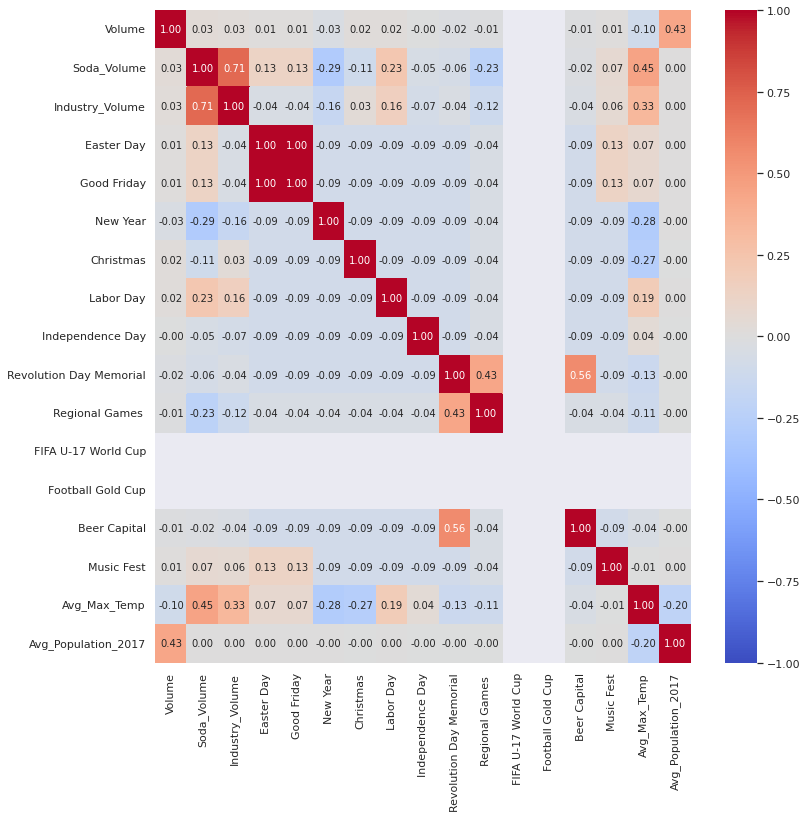

In [366]:
corr = train_df[train_df.columns[:18]].corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr,vmin=-1,cmap='coolwarm', annot=True, fmt = ".2f")

In [367]:
train_df.drop(columns=['FIFA U-17 World Cup','Football Gold Cup'],inplace=True)
test_df.drop(columns=['FIFA U-17 World Cup','Football Gold Cup'],inplace=True)
df_agen.drop(columns=['FIFA U-17 World Cup','Football Gold Cup'],inplace=True)

In [368]:
x_call = train_df.columns[2:]
X = train_df[x_call]
y = train_df['Volume']

In [369]:
std_call = ['Soda_Volume','Industry_Volume','Avg_Max_Temp','Avg_Population_2017','Avg_Yearly_Household_Income_2017']
scaller = StandardScaler()
std = pd.DataFrame(scaller.fit_transform(X[std_call]),columns=std_call)
std_test = pd.DataFrame(scaller.transform(test_df[std_call]),columns=std_call)
std_agen = pd.DataFrame(scaller.transform(df_agen[std_call]),columns=std_call)

In [370]:
X_std = X.copy()
X_std.loc[:,std_call] = std.values
test_df_std = test_df.copy() 
df_agen_std = df_agen.copy()
test_df_std.loc[:,std_call] = std_test.values 
df_agen_std.loc[:,std_call] = std_agen.values

In [371]:
print(X_std.shape)
X_std.head()

(21000, 40)


,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,-1.697382,-0.815995,0,0,1,0,0,0,0,0,0,0,-0.696539,-1.072907,-0.376197,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-01,-1.697382,-0.815995,0,0,1,0,0,0,0,0,0,0,-0.696539,-1.072907,-0.376197,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-01,-1.697382,-0.815995,0,0,1,0,0,0,0,0,0,0,-1.609134,0.619805,-0.897003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2013-01-01,-1.697382,-0.815995,0,0,1,0,0,0,0,0,0,0,-1.147700,0.747876,1.173208,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-01,-1.697382,-0.815995,0,0,1,0,0,0,0,0,0,0,-0.696539,-1.072907,-0.376197,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [372]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.30, random_state = 217,shuffle=True)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(14700, 40)
(14700,)
(6300, 40)
(6300,)


In [373]:
# Spot all methods want to be used
models = []
models.append(('RF', RandomForestRegressor()))
models.append(('LR', LinearRegression()))
models.append(('GB', GradientBoostingRegressor()))
models.append(('LG', LGBMRegressor()))
models.append(('KN', KNeighborsRegressor()))
models.append(('XG', XGBRegressor(objective='reg:squarederror')))

In [374]:
results = pd.DataFrame({'Score':['fit_time', 'score_time', 'test_R_Square', 'test_MSE', 'test_MAE']})
for name, model in models:
    # Spot all scorers want to be used
    scorer = {'R_Square' : 'r2',
              'MSE'  : 'neg_mean_squared_error',
              'MAE' : 'neg_mean_absolute_error'}
        
    # Cross Validation Model
    kfold = KFold(n_splits=5, random_state=217,shuffle=True)
    cv_results = cross_validate(model,X_train, y_train,cv=kfold,scoring=scorer)
    cv_results['test_R_Square'] = cv_results['test_R_Square']*100
    cv_results['test_MSE'] = np.log(np.sqrt(np.abs(cv_results['test_MSE'])))*10
    cv_results['test_MAE'] = np.log(np.abs(cv_results['test_MAE']))*10
    results[name] = pd.DataFrame(cv_results).mean().values

In [375]:
results

,Score,RF,LR,GB,LG,KN,XG
0,fit_time,4.994845,0.024045,1.363954,0.171337,0.006985,1.139319
1,score_time,0.100504,0.004567,0.008991,0.020451,0.923173,0.010593
2,test_R_Square,95.675760,41.451708,66.156522,94.634654,58.453870,65.960436
3,test_MSE,63.232618,76.269354,73.529136,64.318615,74.551363,73.556059
4,test_MAE,54.680820,71.741095,67.690328,57.674629,67.668241,67.707385


In [376]:
model_rf = RandomForestRegressor()

model_rf.fit(X_train, y_train)

predictions = model_rf.predict(X_test)
print("R Square: %.3f" % r2_score(y_test, predictions))
print("RMSE: %f" % np.sqrt(mean_squared_error(y_test, predictions)))
print("MAE: %f" % mean_absolute_error(y_test, predictions))

R Square: 0.954
RMSE: 591.812927
MAE: 235.619320


In [377]:
model_lg = LGBMRegressor()

model_lg.fit(X_train, y_train)

predictions = model_lg.predict(X_test)
print("R Square: %.3f" % r2_score(y_test, predictions))
print("RMSE: %f" % np.sqrt(mean_squared_error(y_test, predictions)))
print("MAE: %f" % mean_absolute_error(y_test, predictions))

R Square: 0.947
RMSE: 636.167995
MAE: 320.039405


In [378]:
model_fix = RandomForestRegressor()
model_fix.fit(X_std, y)

RandomForestRegressor()

In [379]:
def plot_feature_importances(df,n):
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (12, 12))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:n]))), 
            df['importance_normalized'].head(n), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:n]))))
    ax.set_yticklabels(df['feature'].head(n))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [380]:
# Extract feature importances
feature_importance = model_fix.feature_importances_
feature_importances = pd.DataFrame({'feature': x_call, 'importance': feature_importance})

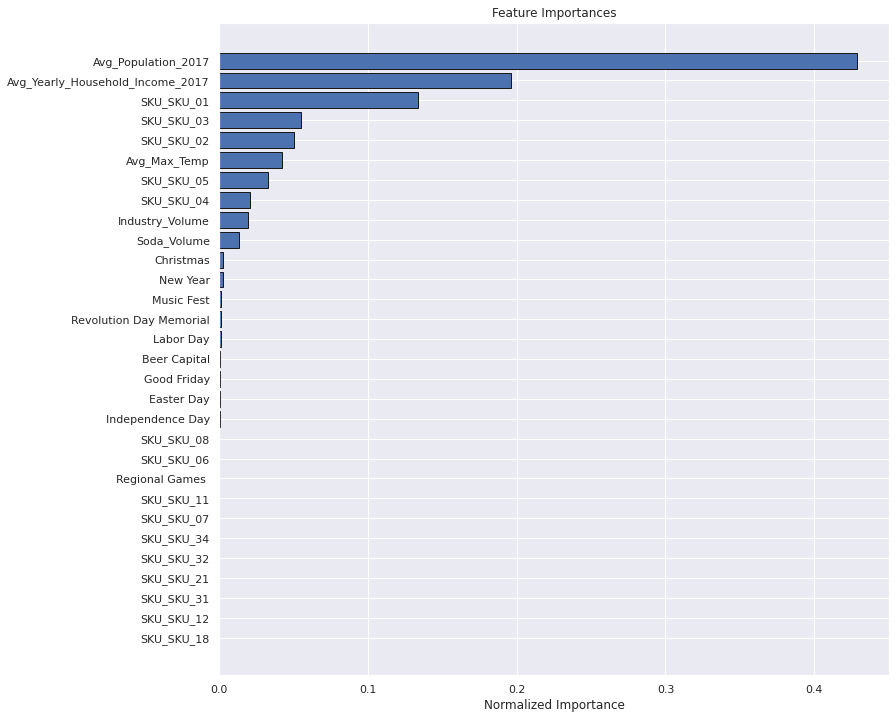

In [381]:
feature_importance = plot_feature_importances(feature_importances,30)

In [382]:
print(test_df.shape)
test_df.head()

(87000, 42)


,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_60,NaN,718394219,492612703,0,0,1,0,0,0,0,0,0,0,22.219737,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-02-01,Agency_60,NaN,753938444,431937346,0,0,0,0,0,0,0,0,0,0,25.637500,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-03-01,Agency_60,NaN,892192092,509281531,1,1,0,0,0,0,0,0,0,1,24.925652,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-04-01,Agency_60,NaN,838099501,532390389,0,0,0,0,0,0,0,0,0,0,27.930736,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-05-01,Agency_60,NaN,864420003,551755254,0,0,0,0,1,0,0,0,0,0,27.555022,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [383]:
pred_test = model_fix.predict(test_df_std[x_call])
test_df.loc[:,'Volume'] = pred_test
print(test_df.shape)
test_df.head()

(87000, 42)


,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_60,22.394925,718394219,492612703,0,0,1,0,0,0,0,0,0,0,22.219737,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-02-01,Agency_60,7.327800,753938444,431937346,0,0,0,0,0,0,0,0,0,0,25.637500,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-03-01,Agency_60,8.013675,892192092,509281531,1,1,0,0,0,0,0,0,0,1,24.925652,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-04-01,Agency_60,14.969775,838099501,532390389,0,0,0,0,0,0,0,0,0,0,27.930736,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2013-05-01,Agency_60,12.438675,864420003,551755254,0,0,0,0,1,0,0,0,0,0,27.555022,2180611,211936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [384]:
def split(x):
    x = x.split('_')
    return x[1]+'_'+x[2]

test_df.loc[:,'SKU'] = test_df[test_df.columns[17:]].idxmax(axis=1).apply(split).values

In [385]:
test_df.drop(columns=test_df.iloc[:,17:-1].columns,inplace=True)
test_df.reset_index(inplace=True)
print(test_df.shape)
test_df.head()

(87000, 19)


,YearMonth,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU
0,2013-01-01,Agency_60,22.394925,718394219,492612703,0,0,1,0,0,0,0,0,0,0,22.219737,2180611,211936,SKU_34
1,2013-02-01,Agency_60,7.327800,753938444,431937346,0,0,0,0,0,0,0,0,0,0,25.637500,2180611,211936,SKU_34
2,2013-03-01,Agency_60,8.013675,892192092,509281531,1,1,0,0,0,0,0,0,0,1,24.925652,2180611,211936,SKU_34
3,2013-04-01,Agency_60,14.969775,838099501,532390389,0,0,0,0,0,0,0,0,0,0,27.930736,2180611,211936,SKU_34
4,2013-05-01,Agency_60,12.438675,864420003,551755254,0,0,0,0,1,0,0,0,0,0,27.555022,2180611,211936,SKU_34


In [386]:
pivot = pd.pivot_table(test_df, values='Volume', index='YearMonth', columns=['Agency','SKU'])
print(pivot.shape)
pivot.head()

(60, 1450)


Agency      Agency_01                                                          \
SKU            SKU_01     SKU_02     SKU_03      SKU_04     SKU_05     SKU_06   
YearMonth                                                                       
2013-01-01   70.88580   72.74880  35.182602  201.561687  15.367311  18.645147   
2013-02-01   95.91588   87.88392  45.193446  251.446500  15.638247  23.982351   
2013-03-01  115.12800  103.70808  49.032021  341.069484  28.164429  36.647913   
2013-04-01  136.33164  119.28816  58.751547  350.245450  23.482428  33.429042   
2013-05-01  142.07292  148.00536  67.690998  415.483923  28.765224  41.692773   

Agency                                                                        \
SKU            SKU_07     SKU_08     SKU_11     SKU_12     SKU_14     SKU_15   
YearMonth                                                                      
2013-01-01  18.645147  10.100781   8.043732  18.645147  18.645147  18.645147   
2013-02-01  23.982351  11.965287   9.916002  23.982351  23.982351  23.982351   
2013-03-01  36.647913  14.807994  18.892884  36.647913  36.647913  36.647913   
2013-04-01  33.429042  11.745361  15.669837  33.429042  33.429042  33.429042   
2013-05-01  41.692773  16.360512  19.814262  41.692773  41.692773  41.692773   

Agency                                                                        \
SKU            SKU_17     SKU_18     SKU_20     SKU_21     SKU_22     SKU_23   
YearMonth                                                                      
2013-01-01  18.645147  18.645147  18.645147  18.645147  18.645147  18.645147   
2013-02-01  23.982351  23.982351  23.982351  23.982351  23.982351  23.982351   
2013-03-01  36.647913  36.647913  36.647913  36.647913  36.647913  36.647913   
2013-04-01  33.429042  33.429042  33.429042  33.429042  33.429042  33.429042   
2013-05-01  41.692773  41.692773  41.692773  41.692773  41.692773  41.692773   

Agency                                                                        \
SKU            SKU_24     SKU_26     SKU_27     SKU_28     SKU_31     SKU_32   
YearMonth                                                                      
2013-01-01  18.645147  18.645147  18.645147  18.645147  18.645147  18.645147   
2013-02-01  23.982351  23.982351  23.982351  23.982351  23.982351  23.982351   
2013-03-01  36.647913  36.647913  36.647913  36.647913  36.647913  36.647913   
2013-04-01  33.429042  33.429042  33.429042  33.429042  33.429042  33.429042   
2013-05-01  41.692773  41.692773  41.692773  41.692773  41.692773  41.692773   

Agency                  Agency_02                                           \
SKU            SKU_34      SKU_01        SKU_02        SKU_03       SKU_04   
YearMonth                                                                    
2013-01-01  18.645147  6398.75385   7552.313640   8303.998458  5104.835528   
2013-02-01  23.982351  7062.56520   8450.966700   9798.797649  4934.602647   
2013-03-01  36.647913  8112.15516  10309.686255  12082.288728  7084.553805   
2013-04-01  33.429042  9135.85281  11001.557805  11566.219978  5896.899498   
2013-05-01  41.692773  9398.90259  12245.631555  12573.662482  7307.435527   

Agency                                                                \
SKU              SKU_05      SKU_06      SKU_07      SKU_08   SKU_11   
YearMonth                                                              
2013-01-01  2359.131765   74.981565   89.548725  140.307786  0.09918   
2013-02-01  2578.135889   77.852610  100.013850  173.541537  0.00000   
2013-03-01  3236.490932   76.981920  118.780275  223.275837  0.14349   
2013-04-01  3234.612853  110.402940  115.218150  215.573674  0.00000   
2013-05-01  3648.349350   86.201490  122.284875  276.754734  0.00000   

Agency                                                                 \
SKU            SKU_12      SKU_14      SKU_15      SKU_17      SKU_18   
YearMonth                                                               
2013-01

In [387]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [388]:
dataset = np.array(pivot)
# choose a number of time steps
n_steps = 12
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

In [389]:
# split into train and validating
train_X, train_y = X[:-12, :], y[:-12,:]
val_X, val_y = X[-12:-3, :], y[-12:-3,:]
test_X, test_y = X[-3:, :], y[-3:,:]

In [390]:
# define model
model = Sequential()
model.add(LSTM(1024, activation='relu', return_sequences=True, input_shape=(n_steps, n_features),recurrent_dropout=0.2))
model.add(LSTM(512, activation='relu',return_sequences=True,recurrent_dropout=0.2))
model.add(LSTM(256, activation='relu',return_sequences=True,recurrent_dropout=0.1))
model.add(LSTM(128, activation='relu',recurrent_dropout=0.1))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse') 

In [391]:
# fit model
history = model.fit(train_X, train_y, epochs=712, batch_size=32, verbose=0, shuffle=False,validation_data=(val_X, val_y))

In [392]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 12, 1024)          10137600  
                                                                 
 lstm_9 (LSTM)               (None, 12, 512)           3147776   
                                                                 
 lstm_10 (LSTM)              (None, 12, 256)           787456    
                                                                 
 lstm_11 (LSTM)              (None, 128)               197120    
                                                                 
 dense_2 (Dense)             (None, 1450)              187050    
                                                                 
Total params: 14,457,002
Trainable params: 14,457,002
Non-trainable params: 0
_________________________________________________________________


In [422]:
    from keras.models import load_model
    
    model.save('my_model1.h5')  # creates a HDF5 file 'my_model.h5'
    del model  # deletes the existing model
    
    # returns a compiled model
    # identical to the previous one
    model = load_model('my_model1.h5')

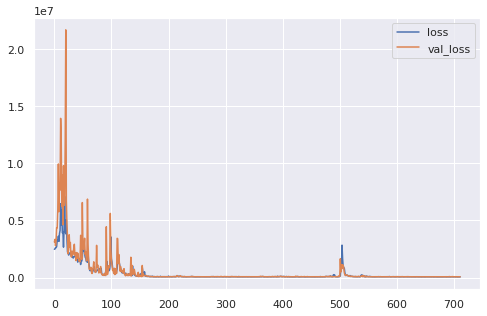

In [393]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [ ]:
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd

fig = go.Figure()
fig.add_trace(go.Scatter(
                x=list(range(1,722)),
                y=history.history['loss'],
                name="Train",
                line_color='deepskyblue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=list(range(1,722)),
                y=history.history['val_loss'],
                name="Test",
                line_color='dimgray',
                opacity=0.8))

# Use date string to set xaxis range
fig.layout.update(title_text="Forecasting Score")
fig.show()

In [395]:
# demonstrate prediction
train_yhat = model.predict(train_X, verbose=0)
print("RMSE of training data : %.3f" % np.sqrt(mean_squared_error(train_y,train_yhat)))

RMSE of training data : 235.108


In [396]:
# demonstrate prediction
val_yhat = model.predict(val_X, verbose=0)
print("RMSE of training data : %.3f" % np.sqrt(mean_squared_error(val_y,val_yhat)))

RMSE of training data : 263.064


In [397]:
# demonstrate prediction
test_yhat = model.predict(test_X, verbose=0)
print("RMSE of testing data : %.3f" % np.sqrt(mean_squared_error(test_y,test_yhat)))

RMSE of testing data : 316.973


In [398]:
# demonstrate prediction
x_input = X[len(X)-1,:]
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)

In [399]:
pivot.loc['2018-01-01',:] = yhat
pivot.index = pd.to_datetime(pivot.index)

In [400]:
vol_for = pd.read_csv('/content/volume_forecast.csv')
print(vol_for.shape)
vol_for.head()

(1450, 3)


,Agency,SKU,Volume
0,Agency_23,SKU_06,NaN
1,Agency_34,SKU_20,NaN
2,Agency_24,SKU_02,NaN
3,Agency_40,SKU_06,NaN
4,Agency_42,SKU_32,NaN


In [401]:
def volume(row):
    agen = row.Agency
    cost = row.SKU
    return pivot[agen,cost]['2018-01-01']

vol_for['Volume'] = vol_for.apply(volume,axis=1)
print(vol_for.shape)

(1450, 3)


In [402]:
vol_for.head(20)

,Agency,SKU,Volume
0,Agency_23,SKU_06,20.563110
1,Agency_34,SKU_20,2.699351
2,Agency_24,SKU_02,113.124367
3,Agency_40,SKU_06,622.718994
4,Agency_42,SKU_32,402.673920
5,Agency_08,SKU_02,2.813570
6,Agency_35,SKU_26,5.434094
7,Agency_13,SKU_18,3.492128
8,Agency_40,SKU_27,2.088997
9,Agency_07,SKU_04,1735.019043


In [403]:
vol_for.tail(20)

,Agency,SKU,Volume
1430,Agency_01,SKU_22,23.870440
1431,Agency_42,SKU_04,131.401276
1432,Agency_46,SKU_20,7.242419
1433,Agency_50,SKU_02,12966.897461
1434,Agency_19,SKU_15,2.351142
1435,Agency_07,SKU_34,22.926615
1436,Agency_29,SKU_27,5.358107
1437,Agency_51,SKU_15,4.250792
1438,Agency_26,SKU_11,5.299726
1439,Agency_43,SKU_24,339.124237


In [404]:
df_agen.head()

,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_06,NaN,718394219,492612703,0,0,1,0,0,0,0,0,0,0,24.079012,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-02-01,Agency_06,NaN,753938444,431937346,0,0,0,0,0,0,0,0,0,0,28.416049,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-03-01,Agency_06,NaN,892192092,509281531,1,1,0,0,0,0,0,0,0,1,28.715493,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-04-01,Agency_06,NaN,838099501,532390389,0,0,0,0,0,0,0,0,0,0,32.113750,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-05-01,Agency_06,NaN,864420003,551755254,0,0,0,0,1,0,0,0,0,0,32.577215,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [405]:
pred = model_fix.predict(df_agen_std[x_call])
df_agen.loc[:,'Volume'] = pred
print(df_agen.shape)
df_agen.head()

(3000, 42)


,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU_SKU_01,SKU_SKU_02,SKU_SKU_03,SKU_SKU_04,SKU_SKU_05,SKU_SKU_06,SKU_SKU_07,SKU_SKU_08,SKU_SKU_11,SKU_SKU_12,SKU_SKU_14,SKU_SKU_15,SKU_SKU_17,SKU_SKU_18,SKU_SKU_20,SKU_SKU_21,SKU_SKU_22,SKU_SKU_23,SKU_SKU_24,SKU_SKU_26,SKU_SKU_27,SKU_SKU_28,SKU_SKU_31,SKU_SKU_32,SKU_SKU_34
YearMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,Agency_06,3390.79932,718394219,492612703,0,0,1,0,0,0,0,0,0,0,24.079012,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-02-01,Agency_06,4054.09536,753938444,431937346,0,0,0,0,0,0,0,0,0,0,28.416049,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-03-01,Agency_06,4314.40668,892192092,509281531,1,1,0,0,0,0,0,0,0,1,28.715493,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-04-01,Agency_06,4724.71494,838099501,532390389,0,0,0,0,0,0,0,0,0,0,32.113750,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-05-01,Agency_06,5237.01417,864420003,551755254,0,0,0,0,1,0,0,0,0,0,32.577215,2104390,228353,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [406]:
df_agen.loc[:,'SKU'] = df_agen[df_agen.columns[17:]].idxmax(axis=1).apply(split).values
df_agen.drop(columns=df_agen.iloc[:,17:-1].columns,inplace=True)
df_agen.reset_index(inplace=True)
print(df_agen.shape)
df_agen.head()

(3000, 19)


,YearMonth,Agency,Volume,Soda_Volume,Industry_Volume,Easter Day,Good Friday,New Year,Christmas,Labor Day,Independence Day,Revolution Day Memorial,Regional Games,Beer Capital,Music Fest,Avg_Max_Temp,Avg_Population_2017,Avg_Yearly_Household_Income_2017,SKU
0,2013-01-01,Agency_06,3390.79932,718394219,492612703,0,0,1,0,0,0,0,0,0,0,24.079012,2104390,228353,SKU_01
1,2013-02-01,Agency_06,4054.09536,753938444,431937346,0,0,0,0,0,0,0,0,0,0,28.416049,2104390,228353,SKU_01
2,2013-03-01,Agency_06,4314.40668,892192092,509281531,1,1,0,0,0,0,0,0,0,1,28.715493,2104390,228353,SKU_01
3,2013-04-01,Agency_06,4724.71494,838099501,532390389,0,0,0,0,0,0,0,0,0,0,32.113750,2104390,228353,SKU_01
4,2013-05-01,Agency_06,5237.01417,864420003,551755254,0,0,0,0,1,0,0,0,0,0,32.577215,2104390,228353,SKU_01


In [407]:
pivot_agen = pd.pivot_table(df_agen.reset_index(), values='Volume', index='YearMonth', columns=['Agency','SKU'])
print(pivot_agen.shape)
pivot_agen.head()

(60, 50)


Agency       Agency_06                                                       \
SKU             SKU_01        SKU_02       SKU_03       SKU_04       SKU_05   
YearMonth                                                                     
2013-01-01  3390.79932   6070.554750  2467.903936  2257.178082  1597.256242   
2013-02-01  4054.09536   7249.415460  3618.633394  2245.031590  1948.252417   
2013-03-01  4314.40668   8683.906560  4330.484503  2681.543715  2341.032939   
2013-04-01  4724.71494   9101.060025  4230.820622  2522.317131  2548.349241   
2013-05-01  5237.01417  10180.688235  4485.943303  2536.074195  2382.639466   

Agency                                                                     \
SKU           SKU_06     SKU_07      SKU_08    SKU_11    SKU_12    SKU_14   
YearMonth                                                                   
2013-01-01  39.37248  51.157425  191.047581  0.000000  4.031250  1.250310   
2013-02-01  42.45372  66.720150  246.625884  0.000000  3.684000  0.306294   
2013-03-01  60.52104  82.729800  305.239748  0.021726  4.708476  0.115446   
2013-04-01  45.20664  75.198450  301.114048  0.000000  5.367750  0.288891   
2013-05-01  55.38456  85.141425  375.743838  0.000000  4.735500  0.089034   

Agency                                                                  \
SKU           SKU_15    SKU_17    SKU_18    SKU_20    SKU_21    SKU_22   
YearMonth                                                                
2013-01-01  1.979622  0.000000  0.000000  0.000000  0.000000  0.000000   
2013-02-01  0.858732  0.000000  0.000000  0.000000  0.000000  0.000000   
2013-03-01  4.305246  0.021726  0.021726  0.042813  0.021726  0.021726   
2013-04-01  0.188379  0.000000  0.000000  0.000000  0.000000  0.000000   
2013-05-01  0.398310  0.000000  0.000000  0.261328  0.000000  0.000000   

Agency                                                                  \
SKU           SKU_23    SKU_24    SKU_26    SKU_27    SKU_28    SKU_31   
YearMonth                                                                
2013-01-01  0.000000  0.000000  0.000000  0.000000  0.000000  5.044500   
2013-02-01  0.000000  0.000000  0.000000  0.000000  0.000000  4.787850   
2013-03-01  0.021726  0.021726  0.021726  0.021726  0.021726  3.424551   
2013-04-01  0.000000  0.000000  0.000000  0.000000  0.000000  4.849800   
2013-05-01  0.000000  0.000000  0.000000  0.000000  0.000000  5.115300   

Agency                              Agency_14                           \
SKU            SKU_32     SKU_34       SKU_01       SKU_02      SKU_03   
YearMonth                                                                
2013-01-01  57.175761   5.606475  5343.201669  4891.274670  618.958138   
2013-02-01  53.980080   7.779150  6058.220940  6082.116115  658.044022   
2013-03-01  88.759614   9.850050  7179.014475  6229.671330  731.047677   
2013-04-01  27.817974  21.253275  6496.190655  5994.105150  873.357712   
2013-05-01  43.131450  10.712925  6956.108723  6232.117560  802.679826   

Agency                                                                \
SKU              SKU_04      SKU_05    SKU_06     SKU_07      SKU_08   
YearMonth                                                              
2013-01-01  2281.555386  496.593103  39.28176  49.356450  191.047581   
2013-02-01  2233.593793  562.993563  36.74052  60.237525  229.842549   
2013-03-01  2941.439174  585.065464  55.68696  76.707375  286.234616   
2013-04-01  2460.847620  765.228966  30.14064  71.061075  271.355698   
2013-05-01  2634.562475  825.077445  49.30308  77.632200  308.220042   

Agency                                                                  \
SKU           SKU_11    SKU_12    SKU_14    SKU_15    SKU_17    SKU_18   
YearMonth                                                                
2013-01-01  0.000000  3.177000  0.667116  2.003904  0.000000  0.000000   
2013-02-01  0.000000  4.242000  0.000000  1.171074  0.000000  0.000000   
2013-03-01  0.126112  4.

In [408]:
dataset = np.array(pivot_agen)
# choose a number of time steps
n_steps = 12
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

In [409]:
# split into train and validating
train_X, train_y = X[:-12, :], y[:-12,:]
val_X, val_y = X[-12:-3, :], y[-12:-3,:]
test_X, test_y = X[-3:, :], y[-3:,:]

In [410]:
# define model
model = Sequential()
# define model
model = Sequential()
model.add(LSTM(1024, activation='relu', return_sequences=True, input_shape=(n_steps, n_features),recurrent_dropout=0.2))
model.add(LSTM(512, activation='relu',return_sequences=True,recurrent_dropout=0.2))
model.add(LSTM(256, activation='relu',return_sequences=True,recurrent_dropout=0.1))
model.add(LSTM(128, activation='relu',recurrent_dropout=0.1))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

In [411]:
# fit model
history = model.fit(train_X, train_y, epochs=712, batch_size=32, verbose=0, shuffle=False,validation_data=(val_X, val_y))

In [412]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 12, 1024)          4403200   
                                                                 
 lstm_13 (LSTM)              (None, 12, 512)           3147776   
                                                                 
 lstm_14 (LSTM)              (None, 12, 256)           787456    
                                                                 
 lstm_15 (LSTM)              (None, 128)               197120    
                                                                 
 dense_3 (Dense)             (None, 50)                6450      
                                                                 
Total params: 8,542,002
Trainable params: 8,542,002
Non-trainable params: 0
_________________________________________________________________


In [423]:
    from keras.models import load_model
    
    model.save('my_model2.h5')  # creates a HDF5 file 'my_model.h5'
    del model  # deletes the existing model
    
    # returns a compiled model
    # identical to the previous one
    model = load_model('my_model2.h5')

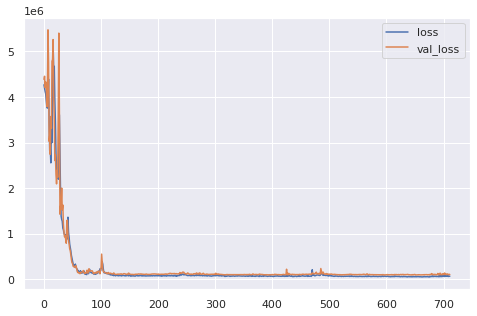

In [413]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [414]:
# demonstrate prediction
train_yhat = model.predict(train_X, verbose=0)
print("RMSE of training data : %.3f" % np.sqrt(mean_squared_error(train_y,train_yhat)))

RMSE of training data : 228.179


In [415]:
# demonstrate prediction
val_yhat = model.predict(val_X, verbose=0)
print("RMSE of training data : %.3f" % np.sqrt(mean_squared_error(val_y,val_yhat)))

RMSE of training data : 320.048


In [416]:
# demonstrate prediction
test_yhat = model.predict(test_X, verbose=0)
print("RMSE of testing data : %.3f" % np.sqrt(mean_squared_error(test_y,test_yhat)))

RMSE of testing data : 374.790


In [417]:
# demonstrate prediction
x_input = X[len(X)-1,:]
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)

In [418]:
pivot_agen.loc['2018-01-01',:] = yhat
pivot_agen.index = pd.to_datetime(pivot_agen.index)
pivot_agen.tail()

Agency        Agency_06                                                      \
SKU              SKU_01       SKU_02       SKU_03       SKU_04       SKU_05   
YearMonth                                                                     
2017-09-01  3788.341920  7390.337085  5287.392414  2324.030741  1537.861227   
2017-10-01  3499.800480  7927.839525  5196.591258  2259.607917  1506.371585   
2017-11-01  2595.827520  6729.402150  5409.008207  1972.294383  1688.521912   
2017-12-01  3393.475560  6643.335660  3895.143386  3524.942655  1437.690997   
2018-01-01  3689.118896  7671.398926  3849.995117  2181.985596  1591.249756   

Agency                                                                         \
SKU            SKU_06     SKU_07      SKU_08     SKU_11     SKU_12     SKU_14   
YearMonth                                                                       
2017-09-01  31.604040  65.724525  204.981897   2.835978   3.232215   1.370708   
2017-10-01  41.456880  70.193775  197.686981   2.317311   2.784028   0.962174   
2017-11-01  38.290320  83.190000  229.506648   1.569773   2.114054   0.542599   
2017-12-01  60.989760  81.048300  192.007138   1.634007   1.543158   1.638203   
2018-01-01  62.312317  82.481171  222.585938  57.736885 -39.391998 -49.085339   

Agency                                                                       \
SKU           SKU_15     SKU_17     SKU_18     SKU_20     SKU_21     SKU_22   
YearMonth                                                                     
2017-09-01  2.717760   2.749418   2.840025   3.868878   3.012493   2.840025   
2017-10-01  1.719000   2.116733   2.319122   3.932340   2.879618   2.319122   
2017-11-01  1.469035   2.632785   1.587545   3.781688   3.980452   1.587545   
2017-12-01  1.157971   0.937498   1.635178   4.987251   1.359207   1.635178   
2018-01-01  6.055493 -55.927349  21.873810  78.621559 -17.921101 -28.254005   

Agency                                                                       \
SKU           SKU_23     SKU_24     SKU_26    SKU_27      SKU_28     SKU_31   
YearMonth                                                                     
2017-09-01  1.827877   4.242536   4.419640  4.281020    2.777370   6.296190   
2017-10-01  1.740732   4.846628   2.479592  2.409589    2.360473   5.890753   
2017-11-01  1.224331   1.647656   1.565803  1.742805    1.680139   2.432729   
2017-12-01  1.538235   2.158357   1.783825  1.275042    1.547800   1.622808   
2018-01-01 -8.659738  31.061073  49.148785  1.960736 -105.901230 -42.495430   

Agency                              Agency_14                            \
SKU            SKU_32     SKU_34       SKU_01       SKU_02       SKU_03   
YearMonth                                                                 
2017-09-01   0.531648  49.967100  6829.885695  8826.608865  1437.660283   
2017-10-01   0.719514  17.385825  6599.962125  9274.233165  1119.833137   
2017-11-01   2.472291  13.518375  5443.849740  7822.015755  1026.872005   
2017-12-01  27.826053  29.952825  7166.937585  7477.151775  1277.406372   
2018-01-01  62.854267  75.302422  6718.722168  6803.278320   825.838989   

Agency                                                                   \
SKU              SKU_04       SKU_05     SKU_06      SKU_07      SKU_08   
YearMonth                                                                 
2017-09-01  2644.921527  1509.175802  45.194760   54.352275  175.123524   
2017-10-01  2360.470281  1590.119078  52.248420   60.441075  171.760917   
2017-11-01  2545.372995  1519.665857  50.132079   75.937425  116.351052   
2017-12-01  3129.080070  1415.055415  61.017480   85.504275  192.007138   
2018-01-01  2292.617920   998.611816  65.907799  102.311661  235.885849   

Agency                                                                       \
SKU            SKU_11     SKU_12     SKU_14    SKU_15     SKU_17     SKU_18   
YearMonth                                                                     
2017-09-01   

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=pivot_agen.index,
                y=pivot_agen['Agency_06','SKU_01'],
                name="Agency_06 with SKU_01",
                line_color='deepskyblue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=pivot_agen.index,
                y=pivot_agen['Agency_06','SKU_02'],
                name="Agency_06 with SKU_02",
                line_color='darkgoldenrod',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=pivot_agen.index,
                y=pivot_agen['Agency_06','SKU_03'],
                name="Agency_06 with SKU_03",
                line_color='dimgray',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=pivot_agen.index,
                y=pivot_agen['Agency_06','SKU_04'],
                name="Agency_06 with SKU_04",
                line_color='aquamarine',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=pivot_agen.index,
                y=pivot_agen['Agency_06','SKU_05'],
                name="Agency_06 with SKU_03",
                line_color='lightpink',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=pivot_agen.index,
                y=pivot_agen['Agency_14','SKU_01'],
                name="Agency_14 with SKU_01",
                line_color='cornflowerblue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=pivot_agen.index,
                y=pivot_agen['Agency_14','SKU_02'],
                name="Agency_14 with SKU_02",
                line_color='lawngreen',
                opacity=0.8))
fig.add_trace(go.Scatter(
                x=pivot_agen.index,
                y=pivot_agen['Agency_14','SKU_04'],
                name="Agency_14 with SKU_04",
                line_color='lightsalmon',
                opacity=0.8))
fig.add_trace(go.Scatter(
                x=pivot_agen.index,
                y=pivot_agen['Agency_14','SKU_05'],
                name="Agency_14 with SKU_05",
                line_color='indianred',
                opacity=0.8))

# Use date string to set xaxis range
fig.layout.update(title_text="Top Four Recommendation SKU for Agency_06 & Agency_14")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=pivot_agen.index,
                y=pivot_agen['Agency_06','SKU_02'],
                name="Agency_06 with SKU_02",
                line_color='darkgoldenrod',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=pivot_agen.index,
                y=pivot_agen['Agency_06','SKU_01'],
                name="Agency_06 with SKU_01",
                line_color='dimgray',
                opacity=0.8))


fig.add_trace(go.Scatter(
                x=pivot_agen.index,
                y=pivot_agen['Agency_14','SKU_01'],
                name="Agency_14 with SKU_01",
                line_color='cornflowerblue',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=pivot_agen.index,
                y=pivot_agen['Agency_14','SKU_02'],
                name="Agency_14 with SKU_02",
                line_color='lawngreen',
                opacity=0.8))

# Use date string to set xaxis range
fig.layout.update(title_text="Recommendation SKU for Agency_06 & Agency_14")
fig.show()

In [421]:
sku_recom = pd.read_csv('/content/sku_recommendation.csv')
tes = pivot_agen.loc['2018-01-01',:].reset_index()
tes.columns = ['Agency','SKU','Volume']
tes_1 = tes[tes.Agency=='Agency_06']
tes_2 = tes[tes.Agency=='Agency_14']
tes_3 = list(tes_1.loc[tes_1['Volume'].nlargest(2).index,'SKU']) + list(tes_2.loc[tes_2['Volume'].nlargest(2).index,'SKU'])
sku_recom.SKU = tes_3
print(sku_recom)

      Agency     SKU
0  Agency_06  SKU_02
1  Agency_06  SKU_03
2  Agency_14  SKU_02
3  Agency_14  SKU_01
